---
title: Using Centroid Clustering to compare data from two surveys (Satellite S2 data).
subtitle: AgroGeo24 Clustering Workshop Part 4
---

**Please save a copy of this notebook in your Google Drive before running**

Click "File" and "Save a copy in Drive" to save a copy of this notebook to your own Google Drive.

This workshop is accompanied by a live presentation from the workshop leader which gives context and background on the datasets provided and also any follow on conclusions and uses with links to relevant papers and articles.

All data for all parts of this workshop are available [here](https://drive.google.com/drive/folders/1YtDP3x0FxpJjjxD7QM_pOxXvU3VKy9so?usp=sharing). Please download these to a local directory on your computer if you have not already.


In this part of the workshop you will be provided with data from 2 fly overs of [ESA Sentinel 2 Optical Satellite data](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2).

1.  The data were acquired in June 2017 and June 2018 over a peatland site in Ireland
2.  The data were processed Semi-Automatic Classification plugin in QGIS
3.  The data were gridded to a 50 x 50 m grid (See Part 5 for reasoning)
4.  Only Pixels that have been identified as being "Peat" are presented
5.  All coordinate information has been altered to keep the privacy of the land owner

The aim of this workshop is to determine the appropriate number of clusters for each of the two datasets using KMeans clustering and MCASD and then determine the physical reason behind the temporal difference in the clustering solutions.

The input file name is: `AgroGeo24_WS_Part_4_20170620_Sentinel2.csv` and `AgroGeo24_WS_Part_4_20170628_Sentinel2.csv` and should be located in the folder named "Part 4" of the data directory provided.

Please following along with the workshop leader in the first instance until you are familiar with using Google Colab environment.

No coding experience is required to run this code. All the code contains comments describing what each line does. Please click "Show Code" on any section to view the code.

Please feel free to ask questions if you don't understand any parts.

# Section 0

This section sets up the Python environment for the clustering analysis.

It imports essential libraries such as Pandas for data manipulation, NumPy for numerical operations, Matplotlib for data visualization, scikit-learn for machine learning tools, and other supporting libraries.

Additionally, it configures the display.

The code also imports specific functions and modules required for the clustering analysis, such as KMeans

Finally, it sets up tools for working with images, zip files, and file uploads in Google Colab. This preparation ensures that the subsequent code can efficiently perform clustering analysis and handle related tasks.



Press the play button below:

# ⬇

In [ ]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio.v2 as imageio
import matplotlib
import imageio.v2 as imageio
import os
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import MaxNLocator
from PIL import Image
from zipfile import ZipFile
from google.colab import files


# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Section 1

Now we are going to read in the data from your local device. If you have not yet downloaded the necessary data, please do so from [here](https://drive.google.com/drive/folders/1YtDP3x0FxpJjjxD7QM_pOxXvU3VKy9so?usp=sharing).

The Data are in CSV format with the following header descriptors:

1.   Column 1 = X Coordinate
2.   Column 2 = Y Coordinate
3.   Columns 3..N = Data

Press the play button below to select the correct files. They should be called: `AgroGeo24_WS_Part_4_20170620_Sentinel2.csv` and `AgroGeo24_WS_Part_4_20180628_Sentinel2.csv`

You will see a button "Choose files". Click this and navigate to where this file is stored on your machine. Then highlight it and click "open".

Please upload the 2017 dataset first and then the 2018 dataset.

When running the cell, you will see a progress message as the file is uploaded to this Google Colab environment.

In [ ]:
# @title
#### Section 1: Import CSV file  ####

# Prompt the user to upload a file
uploaded_1 = files.upload()
uploaded_2 = files.upload()

# Get the uploaded file name
file_name_1 = list(uploaded_1.keys())[0]
file_name_2 = list(uploaded_2.keys())[0]

# Extract the filename without the extension
file_name_without_extension_1 = os.path.splitext(file_name_1)[0]
file_name_without_extension_2 = os.path.splitext(file_name_2)[0]

# Remove numerical suffixes from the filename
file_name_without_extension_1 = re.sub(r'\(\d+\)', '', file_name_without_extension_1)
file_name_without_extension_2 = re.sub(r'\(\d+\)', '', file_name_without_extension_2)
file_name_without_extension_1 = re.sub(r'\(\ \)', '', file_name_without_extension_1)
file_name_without_extension_2 = re.sub(r'\(\ \)', '', file_name_without_extension_2)

# Read the CSV file into a DataFrame
df_1 = pd.read_csv(file_name_1).round(4)
df_2 = pd.read_csv(file_name_2).round(4)


Saving AgroGeo24_WS_Part_4_20170620_Sentinel2.csv to AgroGeo24_WS_Part_4_20170620_Sentinel2.csv


Saving AgroGeo24_WS_Part_4_20180628_Sentinel2.csv to AgroGeo24_WS_Part_4_20180628_Sentinel2.csv


Excellent. You have now loaded the CSV file into the Google Colab environment and are ready to take a look at the data.

# Section 2

In this section, we're inspecting and refining the dataset. Initially, we showcase a snippet of the original dataset, including its structure and the number of rows.

Next, we perform data cleaning by eliminating rows containing NaN (Not a Number) and blank values. The cleaned dataset is then displayed, again with a snippet and the updated row count.

This process ensures that the dataset is well-prepared for subsequent analyses by removing any instances of missing or empty data.

Note that this dataset contained no blank values, so the number of rows doesn't change


Press the play button to run the code

# ⬇

In [ ]:
# @title
#### Section 2: Data Cleaning ####

# Display the original DataFrame and its shape
print("File 1: Original Data:")
print(df_1.head(5).to_string(index=False))
print(f"Number of rows before cleaning: {df_1.shape[0]}")

print("\nFile 2: Original Data:")
print(df_2.head(5).to_string(index=False))
print(f"Number of rows before cleaning: {df_2.shape[0]}")

# Remove rows with NaN and blank values
df_cleaned_1 = df_1.dropna().replace('', np.nan).dropna()
df_cleaned_2 = df_2.dropna().replace('', np.nan).dropna()

# Display the cleaned DataFrame and its shape
print("\nFile 1: Data after removing NaN and blank values:")
print(df_cleaned_1.head(5).to_string(index=False))
print(f"Number of rows after cleaning: {df_cleaned_1.shape[0]}")

print("\nFile 2: Data after removing NaN and blank values:")
print(df_cleaned_2.head(5).to_string(index=False))
print(f"Number of rows after cleaning: {df_cleaned_2.shape[0]}")

File 1: Original Data:
     X      Y     B1     B2     B3     B4     B5     B6     B7     B8    B8A     B9    B10    B11    B12
9750.0 9000.0 0.0307 0.0361 0.0655 0.0467 0.1144 0.3056 0.3908 0.3858 0.4550 0.0959 0.0113 0.2055 0.0984
9800.0 9000.0 0.0304 0.0347 0.0639 0.0449 0.1124 0.3135 0.3988 0.3915 0.4604 0.0946 0.0113 0.2065 0.0962
9850.0 9000.0 0.0293 0.0323 0.0592 0.0405 0.1056 0.3236 0.4176 0.4080 0.4769 0.0945 0.0112 0.1987 0.0897
9900.0 9000.0 0.0290 0.0316 0.0563 0.0389 0.0997 0.3150 0.4117 0.4017 0.4677 0.0915 0.0111 0.1950 0.0898
9550.0 8950.0 0.0295 0.0300 0.0502 0.0378 0.0877 0.2845 0.3799 0.3697 0.4327 0.0884 0.0114 0.1930 0.0877
Number of rows before cleaning: 16794

File 2: Original Data:
     X      Y     B1     B2     B3     B4     B5     B6     B7     B8    B8A     B9    B10    B11    B12
9750.0 9000.0 0.0326 0.0475 0.0705 0.1039 0.1995 0.1995 0.2407 0.2498 0.2980 0.0828 0.0110 0.3392 0.2006
9800.0 9000.0 0.0332 0.0501 0.0757 0.1095 0.2201 0.2201 0.2653 0.2745 0.326

# Section 3

Building on the cleaned dataset from the previous section, we now visualize the non-coordinate columns through scatter plots for both inputs.

Data from File 1 (2017 S2) is placed alongside data from File 2 (2018 S2)

For information on each band see this [link](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bands/).

Each subplot represents a specific data column, showcasing its spatial distribution across the X and Y coordinates. The color intensity in each plot reflects the values of the corresponding data column.

The number of rows and columns for the subplot grid is dynamically calculated based on the available data columns.

This visualization provides an initial exploration of how different data variables are distributed in the geographical space, setting the stage for further analysis and insights.

Note that only pixels that have been identified as being part of a peatland are included in this analysis (See accompanying presentation).


Press the play button to run the code

# ⬇

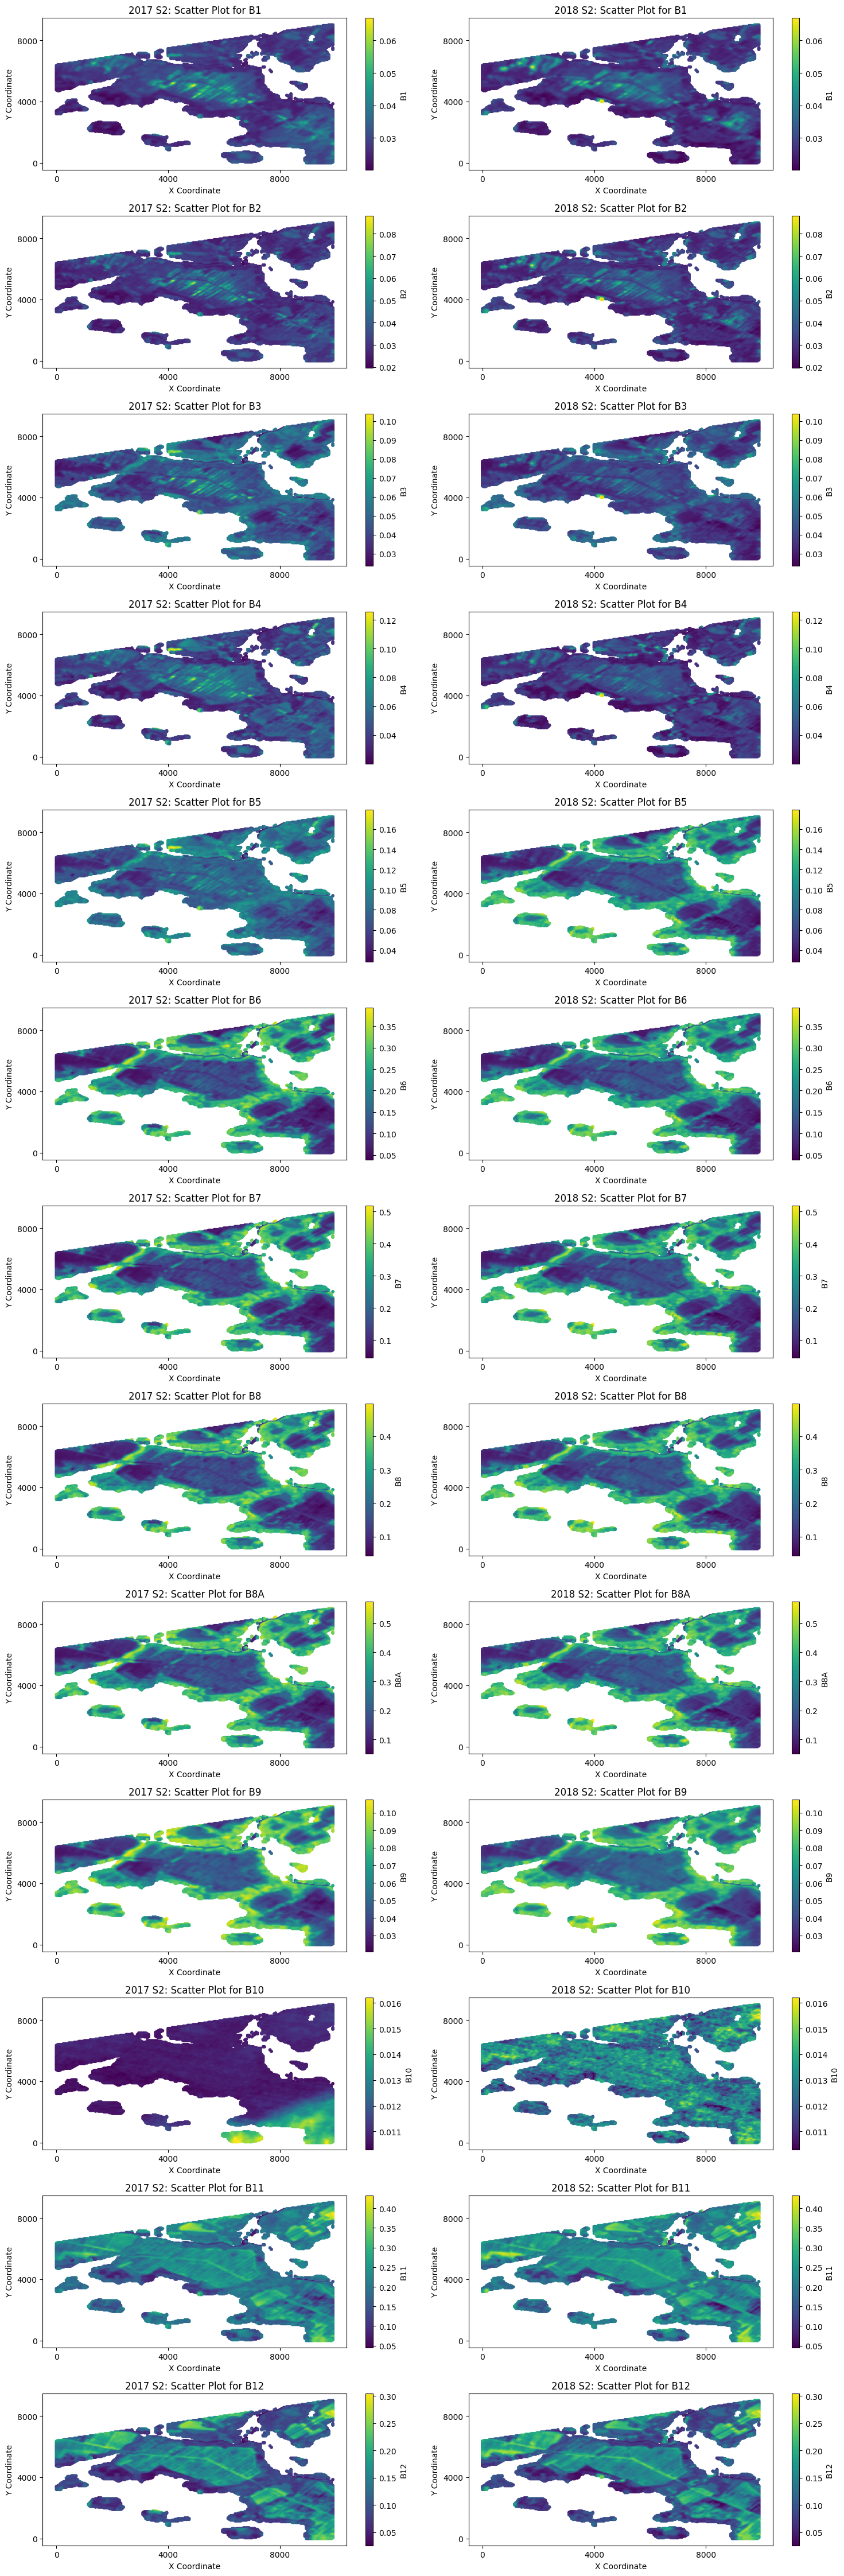

In [ ]:
# @title
#### Section 3 Data Viewing ###

# Assuming df_cleaned_1 and df_cleaned_2 have the same number of columns
data_column_names_1 = df_cleaned_1.columns[2:]
data_column_names_2 = df_cleaned_2.columns[2:]

# Calculate the number of rows and columns for subplots
num_plots = len(data_column_names_1) + len(data_column_names_2)
num_plots_per_row = 2
num_rows = (num_plots + num_plots_per_row - 1) // num_plots_per_row
num_cols = min(num_plots_per_row, 2)

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 45))

# Flatten the axes to simplify indexing
axes = axes.flatten()

# Loop through each data column and create scatter plots
for i, (column_name_1, column_name_2) in enumerate(zip(data_column_names_1, data_column_names_2)):
    # Extract the data for the current column
    column_data_1 = df_cleaned_1[column_name_1]
    column_data_2 = df_cleaned_2[column_name_2]

    # Calculate the position in the subplot grid
    row_index = i // num_cols
    col_index = i % num_cols

    # Create scatter plots for each input
    scatter_1 = axes[i * 2].scatter(df_cleaned_1['X'], df_cleaned_1['Y'], c=column_data_1, cmap='viridis', marker='o', s=10)
    scatter_2 = axes[i * 2 + 1].scatter(df_cleaned_2['X'], df_cleaned_2['Y'], c=column_data_2, cmap='viridis', marker='o', s=10)

    # Set plot properties for the first column
    axes[i * 2].set_title(f'2017 S2: Scatter Plot for {column_name_1}')
    axes[i * 2].set_xlabel('X Coordinate')
    axes[i * 2].set_ylabel('Y Coordinate')

    # Set the number of tick marks on the X and Y axes
    axes[i * 2].xaxis.set_major_locator(MaxNLocator(nbins=3))
    axes[i * 2].yaxis.set_major_locator(MaxNLocator(nbins=3))

    # Add a color bar scaled to the min and max of the current columns
    cbar_1 = plt.colorbar(scatter_1, ax=axes[i * 2], orientation='vertical')
    cbar_1.set_label(column_name_1)

    # Set plot properties for the second column
    axes[i * 2 + 1].set_title(f'2018 S2: Scatter Plot for {column_name_2}')
    axes[i * 2 + 1].set_xlabel('X Coordinate')
    axes[i * 2 + 1].set_ylabel('Y Coordinate')

    # Set the number of tick marks on the X and Y axes
    axes[i * 2 + 1].xaxis.set_major_locator(MaxNLocator(nbins=3))
    axes[i * 2 + 1].yaxis.set_major_locator(MaxNLocator(nbins=3))

    # Add a color bar scaled to the min and max of the current columns
    cbar_2 = plt.colorbar(scatter_1, ax=axes[i * 2 + 1], orientation='vertical')
    cbar_2.set_label(column_name_2)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# Section 4

In this section, we strategically divide our dataset into two key components: coordinates and remaining data. The first two columns, containing coordinate information, are isolated to construct the "Coordinates" DataFrame.

Simultaneously, the remaining data, excluding the initial two columns, forms the "Remaining Data" DataFrame.

**B10 is removed in this instance as it is a measurement of cloud. As these images were acquired on cloud free days, this layer is considered as noise and skews the clustering results**

This separation serves a pivotal purpose—clustering analysis will solely operate on the remaining data. Subsequently, the cluster labels obtained can be associated with their respective X and Y coordinates. This distinction is fundamental for generating geographical cluster maps, allowing us to visually interpret and understand the spatial distribution of clusters across the dataset.

This section also focuses on data normalization, a crucial step before applying clustering algorithms.

The resulting normalized data is displayed, providing an insight into the standardized values across the dataset.

Normalization enhances the accuracy of clustering algorithms, ensuring that features with different scales contribute equally to the clustering process.


Press the play button to run the code

# ⬇


In [ ]:
# @title
#### Section 4 Separate the Data for clustering ####

# Extract coordinate information (assuming it's in the first two columns)
coordinates_1 = df_cleaned_1.iloc[:, :2]
coordinates_2 = df_cleaned_2.iloc[:, :2]

# Extract the remaining data (excluding the first two columns)
remaining_data_1 = df_cleaned_1.iloc[:, 2:]
remaining_data_1 = remaining_data_1.drop(columns = ['B10'])  # Assuming rows are zero-indexed
remaining_data_1 = remaining_data_1.round(4)
remaining_data_2 = df_cleaned_2.iloc[:, 2:]
remaining_data_2 = remaining_data_2.drop(columns = ['B10'])  # Assuming rows are zero-indexed
remaining_data_2 = remaining_data_2.round(4)

# Display the Coordinates DataFrame
print("\n2017 S2 Coordinates:")
print(coordinates_1.head(3).to_string(index=False))  # Use to_string to prevent truncation
print(f"Number of rows: {df_cleaned_1.shape[0]}")

print("\n2018 S2 Coordinates:")
print(coordinates_2.head(3).to_string(index=False))  # Use to_string to prevent truncation
print(f"Number of rows: {df_cleaned_2.shape[0]}")

# Display the Remaining Data DataFrame
print("\n2017 S2 Remaining Data:")
print(remaining_data_1.head(3).to_string(index=False))  # Use to_string to prevent truncation
print(f"Number of rows: {df_cleaned_1.shape[0]}")

print("\n2018 S2 Remaining Data:")
print(remaining_data_2.head(3).to_string(index=False))  # Use to_string to prevent truncation
print(f"Number of rows: {df_cleaned_2.shape[0]}")

# Custom normalization using MinMaxScaler
min_vals_1 = remaining_data_1.min()
max_vals_1 = remaining_data_1.max()
min_vals_2 = remaining_data_2.min()
max_vals_2 = remaining_data_2.max()

normalized_data_1 = (remaining_data_1 - min_vals_1.values) / (max_vals_1.values - min_vals_1.values)
normalized_data_2 = (remaining_data_2 - min_vals_2.values) / (max_vals_2.values - min_vals_2.values)

# Round the normalized data to 4 decimal places
#normalized_data_1 = normalized_data_1.round(4)
#normalized_data_2 = normalized_data_2.round(4)

# Convert the rounded normalized data back to a DataFrame and set column names
normalized_df_1 = pd.DataFrame(normalized_data_1, columns=remaining_data_1.columns)
normalized_df_2 = pd.DataFrame(normalized_data_2, columns=remaining_data_2.columns)


# Display the normalized data
print("\n2017 S2 Normalized Data:")
print(normalized_data_1.head(3).to_string(index=False))  # Use to_string to prevent truncation
print(f"Number of rows: {df_cleaned_1.shape[0]}")

print("\n2018 S2 Normalized Data:")
print(normalized_data_2.head(3).to_string(index=False))  # Use to_string to prevent truncation
print(f"Number of rows: {df_cleaned_2.shape[0]}")


2017 S2 Coordinates:
     X      Y
9750.0 9000.0
9800.0 9000.0
9850.0 9000.0
Number of rows: 16793

2018 S2 Coordinates:
     X      Y
9750.0 9000.0
9800.0 9000.0
9850.0 9000.0
Number of rows: 16793

2017 S2 Remaining Data:
    B1     B2     B3     B4     B5     B6     B7     B8    B8A     B9    B11    B12
0.0307 0.0361 0.0655 0.0467 0.1144 0.3056 0.3908 0.3858 0.4550 0.0959 0.2055 0.0984
0.0304 0.0347 0.0639 0.0449 0.1124 0.3135 0.3988 0.3915 0.4604 0.0946 0.2065 0.0962
0.0293 0.0323 0.0592 0.0405 0.1056 0.3236 0.4176 0.4080 0.4769 0.0945 0.1987 0.0897
Number of rows: 16793

2018 S2 Remaining Data:
    B1     B2     B3     B4     B5     B6     B7     B8    B8A     B9    B11    B12
0.0326 0.0475 0.0705 0.1039 0.1995 0.1995 0.2407 0.2498 0.2980 0.0828 0.3392 0.2006
0.0332 0.0501 0.0757 0.1095 0.2201 0.2201 0.2653 0.2745 0.3260 0.0869 0.3396 0.1994
0.0321 0.0488 0.0739 0.1065 0.2216 0.2216 0.2694 0.2798 0.3351 0.0894 0.3455 0.2005
Number of rows: 16793

2017 S2 Normalized Data:
      B1

# Section 5

This section guides the user in determining the optimal number of clusters (k) for the K-Means algorithm by utilizing both the Elbow Method and Silhouette Scores.

After specifying the maximum number of clusters to consider, the code calculates the Within-Cluster Sum of Squares (WCSS) distance using the Elbow Method. The Elbow Method graph illustrates the trade-off between clustering complexity and WCSS reduction, helping identify an optimal k value.

Simultaneously, Silhouette Scores, a measure of how well-separated clusters are, are computed and presented on the same graph. Silhouette Scores range from -1 to 1, where higher scores indicate better-defined clusters.

When assessing the graph, users should look for the "elbow" point where WCSS plateaus, suggesting diminishing returns with additional clusters.

Additionally, a high Silhouette Score at the "elbow" reinforces the choice, ensuring a balance between compact clusters and distinct cluster boundaries for effective clustering

When running the cell, you will be prompted to enter the max number of clusters. (i.e., 10).



Press the play button to run the code. 

# ⬇

Enter the maximum number of clusters for the Elbow Method: 10


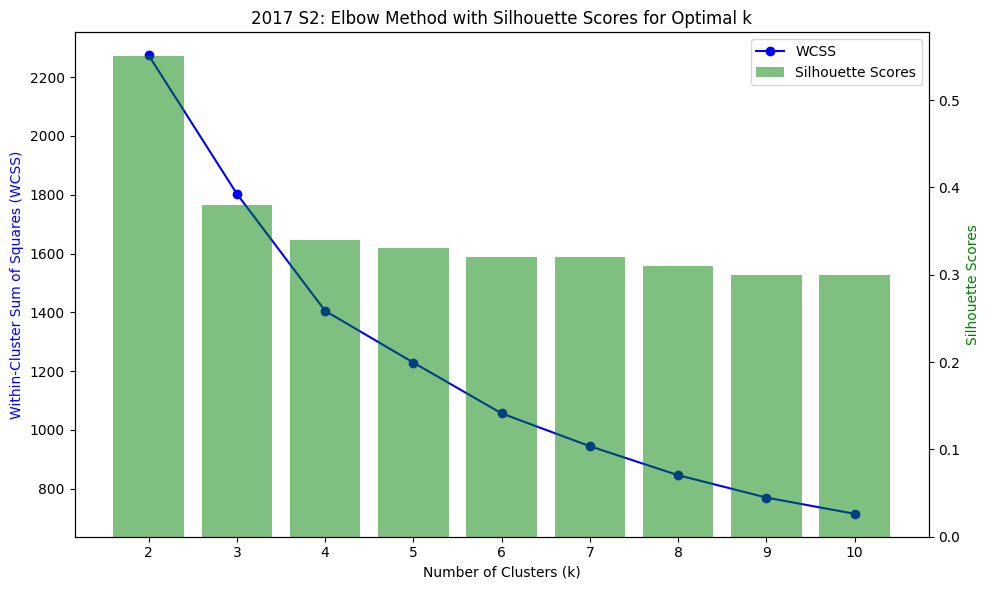

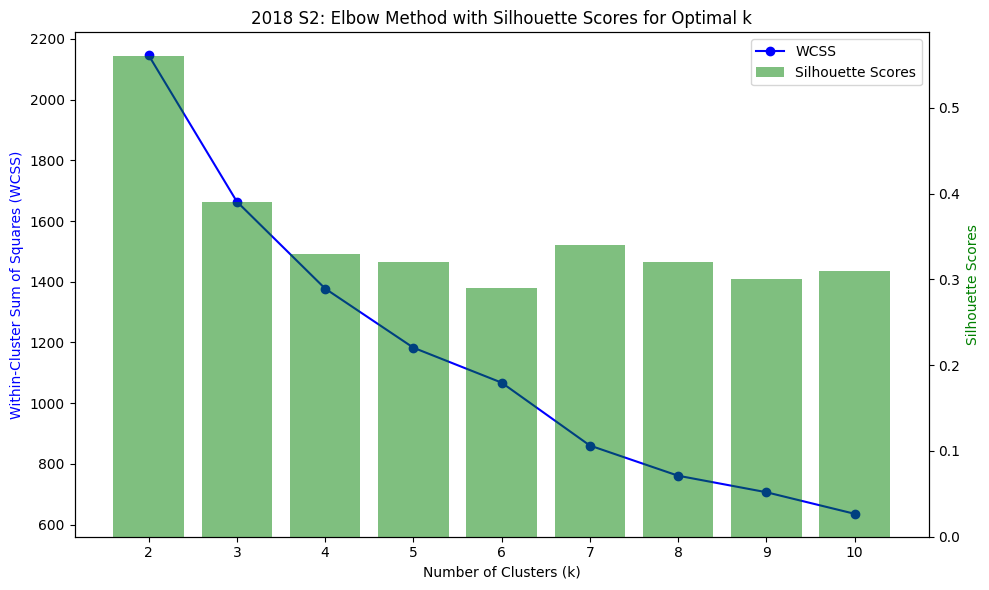

In [ ]:
# @title
#### Section 5 Elbow Method with Silhouette Scores ####

# Prompt the user to choose the maximum number of clusters for the Elbow Method
max_clusters_elbow = int(input("Enter the maximum number of clusters for the Elbow Method: "))

# Calculate the within-cluster sum of squares (WCSS) and Silhouette Scores for different values of k
wcss_1 = []
silhouette_1 = []
wcss_2 = []
silhouette_2 = []
for k in range(2, max_clusters_elbow + 1):
    kmeans_1 = KMeans(n_clusters=k, n_init=1, init='k-means++')
    kmeans_2 = KMeans(n_clusters=k, n_init=1, init='k-means++')
    kmeans_1.fit(normalized_data_1)
    kmeans_2.fit(normalized_data_2)
    sscore_1 = round(silhouette_score(normalized_data_1, kmeans_1.labels_), 2)
    sscore_2 = round(silhouette_score(normalized_data_2, kmeans_2.labels_), 2)
    silhouette_1.append(sscore_1)
    silhouette_2.append(sscore_2)
    wcss_1.append(kmeans_1.inertia_)
    wcss_2.append(kmeans_2.inertia_)

# Plot the Elbow Method graph with Silhouette Scores as a bar graph for 2017 S2
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WCSS on the left y-axis
ax1.plot(range(2, max_clusters_elbow + 1), wcss_1, marker='o', color='blue', label='WCSS')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)', color='blue')

# Set the x-axis ticks to show only integers
plt.xticks(range(2, max_clusters_elbow + 1))

# Create a second y-axis for Silhouette Scores
ax2 = ax1.twinx()
ax2.bar(range(2, max_clusters_elbow + 1), silhouette_1, color='green', alpha=0.5, label='Silhouette Scores')
ax2.set_ylabel('Silhouette Scores', color='green')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('2017 S2: Elbow Method with Silhouette Scores for Optimal k')
fig.tight_layout()
plt.show()

# Plot the Elbow Method graph with Silhouette Scores as a bar graph for 2018 S2
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WCSS on the left y-axis
ax1.plot(range(2, max_clusters_elbow + 1), wcss_2, marker='o', color='blue', label='WCSS')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)', color='blue')

# Set the x-axis ticks to show only integers
plt.xticks(range(2, max_clusters_elbow + 1))

# Create a second y-axis for Silhouette Scores
ax2 = ax1.twinx()
ax2.bar(range(2, max_clusters_elbow + 1), silhouette_2, color='green', alpha=0.5, label='Silhouette Scores')
ax2.set_ylabel('Silhouette Scores', color='green')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('2018 S2: Elbow Method with Silhouette Scores for Optimal k')
fig.tight_layout()
plt.show()


# Section 6

In this section, users will perform K-Means clustering on the preprocessed Satellite data.

The optimal number of clusters (k) can be determined by referencing the results from the previous Elbow Method and Silhouette Scores analysis (Section 5). After entering the desired number of clusters, the code applies K-Means clustering and displays key information.

The results include a count of occurrences for each cluster label via a plot of the classified image and "spectral" graph showing the cluster centers.

The scatter plot provides an overview of spatial distribution of the clusters, while the line plot illustrates how cluster center values vary across the survey

You will be prompted to enter the number of clusters for both 2017 and 2018 S2 datasets, which should be based on the Elbow and Silhouette results.

Even without knowing the most appropriate number of clusters what does this analysis tell you about the Satellite data across this survey and also differences in data with time?


Press the play button to run the code.

# ⬇

Enter the number of clusters for 2017 S2 K-Means: 5
Enter the number of clusters for 2018 S2 K-Means: 5

2017 S2 Count of Each Cluster Label:
Cluster 0: 4629 occurrences
Cluster 1: 3269 occurrences
Cluster 2: 2877 occurrences
Cluster 3: 1900 occurrences
Cluster 4: 4118 occurrences

2018 S2 Count of Each Cluster Label:
Cluster 0: 4221 occurrences
Cluster 1: 3524 occurrences
Cluster 2: 2309 occurrences
Cluster 3: 3006 occurrences
Cluster 4: 3733 occurrences


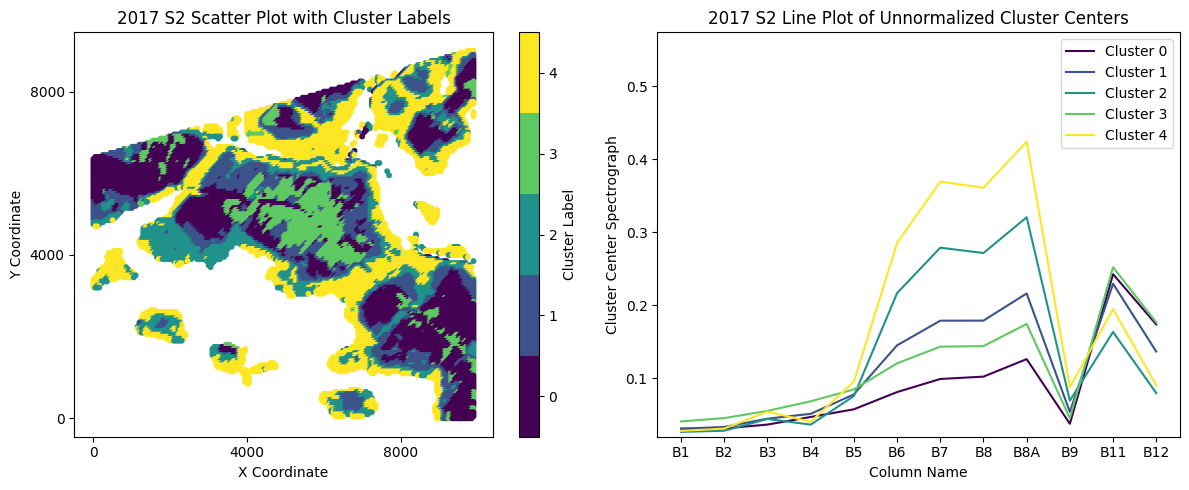

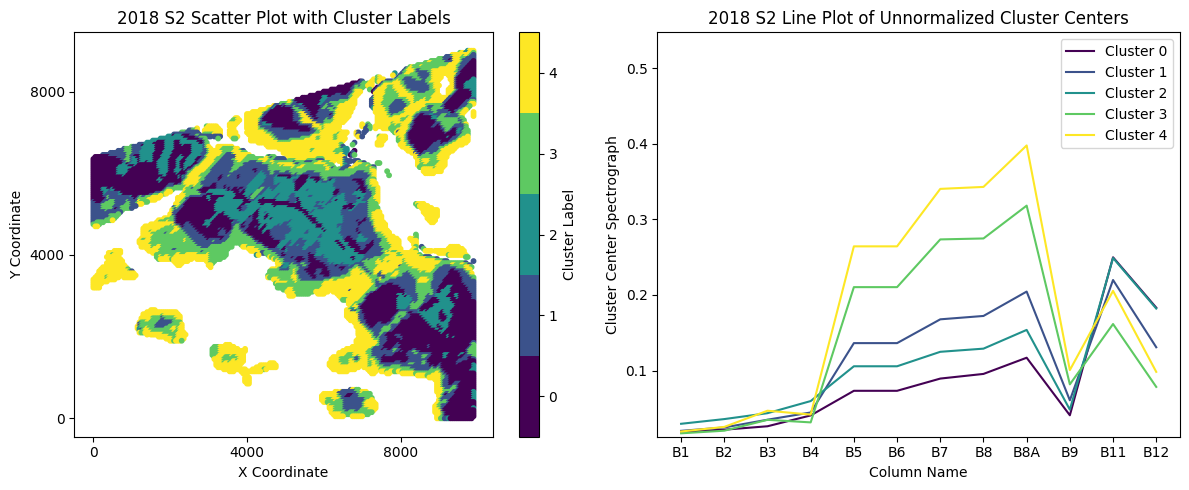

In [ ]:
# @title
##### Section 6 K Means Clustering ####

### Section 6.1 Perform K Means Clustering ###

# Prompt the user to choose the number of clusters for K-Means
num_clusters_1 = int(input("Enter the number of clusters for 2017 S2 K-Means: "))
num_clusters_2 = int(input("Enter the number of clusters for 2018 S2 K-Means: "))

# Initialize the K-Means model
kmeans_1 = KMeans(n_clusters=num_clusters_1, init = 'k-means++', n_init=1)
kmeans_2 = KMeans(n_clusters=num_clusters_2, init = 'k-means++', n_init=1)

# Fit the K-Means model to the normalized data
kmeans_1.fit(normalized_data_1)
kmeans_2.fit(normalized_data_2)

# Get the cluster labels for each data point
cluster_labels_1 = kmeans_1.labels_
cluster_labels_2 = kmeans_2.labels_

# Get the cluster centers
cluster_centers_1 = kmeans_1.cluster_centers_
cluster_centers_2 = kmeans_2.cluster_centers_

### Section 6.2 Sort the Cluster centers ###

# Calculate the distances of cluster centers from the origin (0, 0)
distances_from_origin_1 = np.sqrt(np.sum(cluster_centers_1 ** 2, axis=1))
distances_from_origin_2 = np.sqrt(np.sum(cluster_centers_2 ** 2, axis=1))

# Sort cluster centers based on distances from the origin
sorted_indices_1 = np.argsort(distances_from_origin_1)
sorted_indices_2 = np.argsort(distances_from_origin_2)

# Sort cluster centers and labels
sorted_cluster_centers_1 = cluster_centers_1[sorted_indices_1]
sorted_cluster_centers_2 = cluster_centers_2[sorted_indices_2]
sorted_cluster_labels_1 = np.zeros_like(cluster_labels_1)
sorted_cluster_labels_2 = np.zeros_like(cluster_labels_2)

# Relabel the cluster labels based on the sorted order
for new_label_1, old_label_1 in enumerate(sorted_indices_1):
    sorted_cluster_labels_1[cluster_labels_1 == old_label_1] = new_label_1

for new_label_2, old_label_2 in enumerate(sorted_indices_2):
    sorted_cluster_labels_2[cluster_labels_2 == old_label_2] = new_label_2

# Calculate the count of each cluster label
cluster_labels_count_1 = dict(zip(*np.unique(sorted_cluster_labels_1, return_counts=True)))
cluster_labels_count_2 = dict(zip(*np.unique(sorted_cluster_labels_2, return_counts=True)))

### Section 6.3 Denormalize the cluster centers ###

# Denormalize the data using the inverse transformation
cluster_centers_original_scale_1 = sorted_cluster_centers_1 * (max_vals_1.values - min_vals_1.values) + min_vals_1.values
cluster_centers_original_scale_2 = sorted_cluster_centers_2 * (max_vals_2.values - min_vals_2.values) + min_vals_2.values

### Section 6.4 Display Clustering counts for visual QC ###

# Display the count of each cluster label
print("\n2017 S2 Count of Each Cluster Label:")
for label_1, count_1 in cluster_labels_count_1.items():
    print(f"Cluster {label_1}: {count_1} occurrences")

print("\n2018 S2 Count of Each Cluster Label:")
for label_2, count_2 in cluster_labels_count_2.items():
    print(f"Cluster {label_2}: {count_2} occurrences")

### Section 6.5 Save results to CSV ###

# Create a DataFrame with X, Y, Cluster, and Remaining Data
clustered_data_df_1 = pd.DataFrame({
    'X': coordinates_1['X'],
    'Y': coordinates_1['Y'],
    'Cluster Number': sorted_cluster_labels_1,
    **{f'{col}': remaining_data_1[col] for col in remaining_data_1.columns}
})
clustered_data_df_2 = pd.DataFrame({
    'X': coordinates_2['X'],
    'Y': coordinates_2['Y'],
    'Cluster Number': sorted_cluster_labels_2,
    **{f'{col}': remaining_data_2[col] for col in remaining_data_2.columns}
})
clustered_data_df_1 = clustered_data_df_1.round(4)
clustered_data_df_2 = clustered_data_df_2.round(4)

# Create a DataFrame with Cluster center data
center_data_df_1 = pd.DataFrame(cluster_centers_original_scale_1, columns=remaining_data_1.columns)
center_data_df_2 = pd.DataFrame(cluster_centers_original_scale_2, columns=remaining_data_2.columns)

# Add a new column 'Cluster Number' to indicate the cluster number for each row
center_data_df_1.insert(0, 'Cluster Number', range(num_clusters_1))
center_data_df_2.insert(0, 'Cluster Number', range(num_clusters_2))
center_data_df_1 = center_data_df_1.round(4)
center_data_df_2 = center_data_df_2.round(4)

### Section 6.6 Plot KMeans Clustering results ###

# 2017 S2 Create a scatter plot of X, Y, and final cluster label
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Scatter Plot with Cluster Labels
scatter_1 = ax1.scatter(coordinates_1['X'], coordinates_1['Y'], c=sorted_cluster_labels_1, cmap='viridis', marker='o', s=10)

# Set plot properties for Plot 1
ax1.set_title('2017 S2 Scatter Plot with Cluster Labels')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')

# Create a discrete color map with the number of clusters for Plot 1
cmap_discrete_1 = matplotlib.colormaps.get_cmap('viridis')

# Define boundaries for the discrete color map for Plot 1
boundaries_1 = np.arange(-0.5, num_clusters_1, 1)

# Create a BoundaryNorm for the color map for Plot 1
norm_discrete_1 = mcolors.BoundaryNorm(boundaries_1, cmap_discrete_1.N, clip=True)

# Add a discrete color bar with integer cluster labels for Plot 1
cbar_1 = plt.colorbar(scatter_1, ax=ax1, ticks=np.arange(num_clusters_1), cmap=cmap_discrete_1, norm=norm_discrete_1, boundaries=boundaries_1)
cbar_1.set_label('Cluster Label')

# Set the number of tick marks on the X and Y axes for Plot 1
ax1.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=3))

# Plot 2: Line Plot of Unnormalized Cluster Centers
for cluster_label_1 in range(num_clusters_1):
    color_1 = cmap_discrete_1(cluster_label_1 / (num_clusters_1 - 1))  # Match color from scatter plot
    ax2.plot(remaining_data_1.columns, cluster_centers_original_scale_1[cluster_label_1], label=f'Cluster {cluster_label_1}', color=color_1)
    ax2.set_ylim(remaining_data_1.min().min(), remaining_data_1.max().max())

# Set plot properties for Plot 2
ax2.set_title('2017 S2 Line Plot of Unnormalized Cluster Centers')
ax2.set_xlabel('Column Name')
ax2.set_ylabel('Cluster Center Spectrograph')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# 2018 S2 Create a scatter plot of X, Y, and final cluster label
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Scatter Plot with Cluster Labels
scatter_2 = ax1.scatter(coordinates_2['X'], coordinates_2['Y'], c=sorted_cluster_labels_2, cmap='viridis', marker='o', s=10)

# Set plot properties for Plot 1
ax1.set_title('2018 S2 Scatter Plot with Cluster Labels')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')

# Create a discrete color map with the number of clusters for Plot 1
cmap_discrete_2 = matplotlib.colormaps.get_cmap('viridis')

# Define boundaries for the discrete color map for Plot 1
boundaries_2 = np.arange(-0.5, num_clusters_2, 1)

# Create a BoundaryNorm for the color map for Plot 1
norm_discrete_2 = mcolors.BoundaryNorm(boundaries_2, cmap_discrete_2.N, clip=True)

# Add a discrete color bar with integer cluster labels for Plot 1
cbar_2 = plt.colorbar(scatter_2, ax=ax1, ticks=np.arange(num_clusters_2), cmap=cmap_discrete_2, norm=norm_discrete_2, boundaries=boundaries_2)
cbar_2.set_label('Cluster Label')

# Set the number of tick marks on the X and Y axes for Plot 1
ax1.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=3))

# Plot 2: Line Plot of Unnormalized Cluster Centers
for cluster_label_2 in range(num_clusters_2):
    color_2 = cmap_discrete_2(cluster_label_2 / (num_clusters_2 - 1))  # Match color from scatter plot
    ax2.plot(remaining_data_2.columns, cluster_centers_original_scale_2[cluster_label_2], label=f'Cluster {cluster_label_2}', color=color_2)
    ax2.set_ylim(remaining_data_2.min().min(), remaining_data_2.max().max())

# Set plot properties for Plot 2
ax2.set_title('2018 S2 Line Plot of Unnormalized Cluster Centers')
ax2.set_xlabel('Column Name')
ax2.set_ylabel('Cluster Center Spectrograph')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Section 7

This section applies the MCASD (Multiple Cluster Average Standard Deviation) method, designed to aid participants in identifying the optimal number of clusters for each of the datasets.

MCASD was first published as a method by [O'Leary et al 2023](https://doi.org/10.1016/j.geoderma.2023.116348).

MCASD evaluates the stability of cluster centers across multiple attempts and cluster numbers. Participants will input the maximum number of clusters and the maximum number of attempts per cluster.

The code loops through different cluster numbers, applying K-Means clustering multiple times to analyze stability.

The results include GIFs illustrating scatter plots and line plots for each attempt. Additionally, MCASD metrics are calculated, providing insights into the stability and consistency of clusters. A line plot visualizes the MCASD metric across various cluster numbers, aiding participants in selecting the optimal cluster count.

**All results, including plots and metrics, are compressed into a zip file for easy download.**

Please save this ZIP file to "Part 4" of the data directory you were provided with.

The ultimate goal is to assist participants in making informed decisions about the optimal number of clusters for their specific datasets.

When running the cell, you will be prompted to enter the number of max number of clusters (i.e., 10) and max attempts (i.e., 10).

MCASD will be applied to both 2017 and 2018 S2 datasets separately and MCASD plots will be displayed at the end.

Note this might take some time depending on the max number of clusters and max attempts chosen.



Press the play button to run the code. 

# ⬇

Enter the maximum number of clusters for MCASD Method: 10
Enter the maximum number of attempts for MCASD Method: 10

Calculating MCASD Metrics...

MCASD Method clustering complete.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

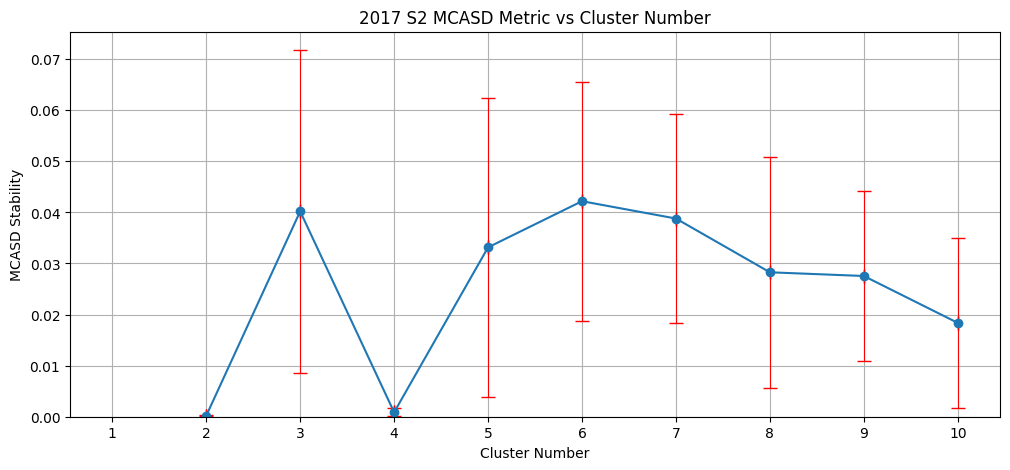

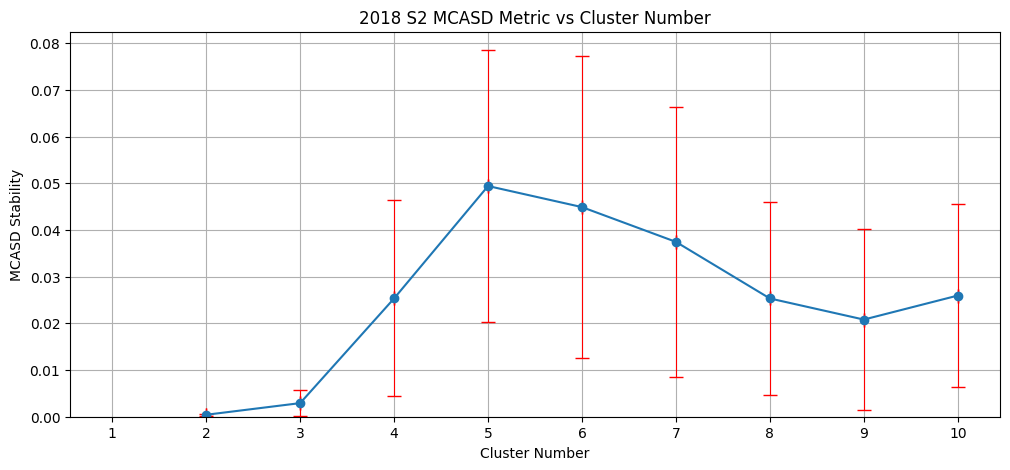

In [ ]:
# @title
#### Section 7 MCASD Method ####
### Section 7.1 Get information from the user ###

# Prompt the user for the maximum number of clusters for MCASD Method
max_num_clusters = int(input("Enter the maximum number of clusters for MCASD Method: "))
# Prompt the user for the maximum number of attempts for MCASD Method
max_attempts = int(input("Enter the maximum number of attempts for MCASD Method: "))

### Section 7.2 Loop for MCASD Method ###
# Create a DataFrame to store MCASD Metrics
mcasd_metrics_df_1 = pd.DataFrame(index=['MCASD Metric', 'MCASD Error'], columns=range(1, max_num_clusters + 1))
mcasd_metrics_df_2 = pd.DataFrame(index=['MCASD Metric', 'MCASD Error'], columns=range(1, max_num_clusters + 1))

print(f"\nCalculating MCASD Metrics...")

# Create a zip file to store all results
zip_filename = f'AgroGeo24_WS_Part_4_kmeans_plots.zip'
with ZipFile(zip_filename, 'w') as zip_file:

    # Loop through the various number of clusters
    for num_clusters in range(2, max_num_clusters + 1):
        images_attempt_1 = []  # List to store images for the current attempt
        images_attempt_2 = []  # List to store images for the current attempt
        distances_df_1 = pd.DataFrame()  # Initialize distances DataFrame
        distances_df_2 = pd.DataFrame()  # Initialize distances DataFrame

        # Cluster the data a user specified number of times (Attempts)
        for attempt in range(1, max_attempts + 1):
            #print(f"\nNumber of Clusters: {num_clusters}: Attempt {attempt} of {max_attempts}")

            # Initialize the K-Means model
            kmeans_1 = KMeans(n_clusters=num_clusters, n_init=1, init='k-means++')
            kmeans_2 = KMeans(n_clusters=num_clusters, n_init=1, init='k-means++')

            # Fit the K-Means model to the normalized data
            kmeans_1.fit(normalized_data_1)
            kmeans_2.fit(normalized_data_2)

            # Get the cluster labels for each data point
            cluster_labels_1 = kmeans_1.labels_
            cluster_labels_2 = kmeans_2.labels_

            # Get the cluster centers
            cluster_centers_1 = kmeans_1.cluster_centers_
            cluster_centers_2 = kmeans_2.cluster_centers_

            ### Section 7.2.1 Sort the Cluster centers ###

            # Calculate the distances of cluster centers from the origin (0, 0)
            distances_from_origin_1 = np.sqrt(np.sum(cluster_centers_1 ** 2, axis=1))
            distances_from_origin_2 = np.sqrt(np.sum(cluster_centers_2 ** 2, axis=1))

            # Sort cluster centers based on distances from the origin
            sorted_indices_1 = np.argsort(distances_from_origin_1)
            sorted_indices_2 = np.argsort(distances_from_origin_2)

            # Sort cluster centers and labels
            sorted_cluster_centers_1 = cluster_centers_1[sorted_indices_1]
            sorted_cluster_centers_2 = cluster_centers_2[sorted_indices_2]
            sorted_cluster_labels_1 = np.zeros_like(cluster_labels_1)
            sorted_cluster_labels_2 = np.zeros_like(cluster_labels_2)

            # Relabel the cluster labels based on the sorted order
            for new_label_1, old_label_1 in enumerate(sorted_indices_1):
                sorted_cluster_labels_1[cluster_labels_1 == old_label_1] = new_label_1

            for new_label_2, old_label_2 in enumerate(sorted_indices_2):
                sorted_cluster_labels_2[cluster_labels_2 == old_label_2] = new_label_2

            ### Section 7.2.2 Calculate the distance (in the dataspace) between each datapoint and its closest cluster center ###

            # Calculate the distances between cluster centers and data
            distances_1 = np.linalg.norm(normalized_data_1.values[:, np.newaxis, :] - cluster_centers_1, axis=-1)
            distances_2 = np.linalg.norm(normalized_data_2.values[:, np.newaxis, :] - cluster_centers_2, axis=-1)

            # Get the smallest distance for each data point
            min_distances_1 = np.min(distances_1, axis=1)
            min_distances_2 = np.min(distances_2, axis=1)

            # Create a DataFrame for distances with only the smallest distances
            new_column_1 = pd.DataFrame(min_distances_1, columns=[f'Attempt_{attempt}'])
            new_column_2 = pd.DataFrame(min_distances_2, columns=[f'Attempt_{attempt}'])

            # Append the new column to the existing distances_df
            distances_df_1 = pd.concat([distances_df_1, new_column_1], axis=1)
            distances_df_2 = pd.concat([distances_df_2, new_column_2], axis=1)

            ### Section 7.2.3 Denormalize the cluster centers ###

            # Denormalize the data using the inverse transformation
            cluster_centers_original_scale_1 = sorted_cluster_centers_1 * (max_vals_1.values - min_vals_1.values) + min_vals_1.values
            cluster_centers_original_scale_2 = sorted_cluster_centers_2 * (max_vals_2.values - min_vals_2.values) + min_vals_2.values

            ### Section 7.2.4 Create and save plots for later GIF creation ###

            # 2017 S2 Create a scatter plot of X, Y, and final cluster label
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Plot 1: Scatter Plot with Cluster Labels
            scatter_1 = ax1.scatter(coordinates_1['X'], coordinates_1['Y'], c=sorted_cluster_labels_1, cmap='viridis', marker='o', s=10)

            # Set plot properties for Plot 1
            ax1.set_title(f'2017 S2 Scatter Plot with Cluster Labels: Attempt {attempt}, Clusters {num_clusters}')
            ax1.set_xlabel('X Coordinate')
            ax1.set_ylabel('Y Coordinate')

            # Create a discrete color map with the number of clusters for Plot 1
            cmap_discrete_1 = matplotlib.colormaps.get_cmap('viridis')

            # Define boundaries for the discrete color map for Plot 1
            boundaries_1 = np.arange(-0.5, num_clusters_1, 1)

            # Create a BoundaryNorm for the color map for Plot 1
            norm_discrete_1 = mcolors.BoundaryNorm(boundaries_1, cmap_discrete_1.N, clip=True)

            # Add a discrete color bar with integer cluster labels for Plot 1
            cbar_1 = plt.colorbar(scatter_1, ax=ax1, ticks=np.arange(num_clusters_1), cmap=cmap_discrete_1, norm=norm_discrete_1, boundaries=boundaries_1)
            cbar_1.set_label('Cluster Label')

            # Set the number of tick marks on the X and Y axes for Plot 1
            ax1.xaxis.set_major_locator(MaxNLocator(nbins=3))
            ax1.yaxis.set_major_locator(MaxNLocator(nbins=3))

            # Plot 2: Line Plot of Unnormalized Cluster Centers
            for cluster_label_1 in range(num_clusters):
                color_1 = cmap_discrete_1(cluster_label_1 / (num_clusters - 1))  # Match color from scatter plot
                ax2.plot(remaining_data_1.columns, cluster_centers_original_scale_1[cluster_label_1], label=f'Cluster {cluster_label_1}', color=color_1)
                ax2.set_ylim(remaining_data_1.min().min(), remaining_data_1.max().max())

            # Set plot properties for Plot 2
            ax2.set_title('2017 S2 Line Plot of Unnormalized Cluster Centers')
            ax2.set_xlabel('Column Name')
            ax2.set_ylabel('Cluster Center Spectrograph')
            ax2.legend()

            # Save the plots
            plot_filename_1 = f'2017 S2 kmeans_plots_Attempt_{attempt}_Num_Clusters_{num_clusters}.png'
            plot_filepath_1 = os.path.join(plot_filename_1)
            plt.tight_layout()
            plt.savefig(plot_filepath_1)
            #plt.show()  # Display the plot
            images_attempt_1.append(plot_filepath_1)  # Append the plot to the list
            plt.close()

            # 2018 S2 Create a scatter plot of X, Y, and final cluster label
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Plot 1: Scatter Plot with Cluster Labels
            scatter_2 = ax1.scatter(coordinates_2['X'], coordinates_2['Y'], c=sorted_cluster_labels_2, cmap='viridis', marker='o', s=10)

            # Set plot properties for Plot 1
            ax1.set_title(f'2018 S2 Scatter Plot with Cluster Labels: Attempt {attempt}, Clusters {num_clusters}')
            ax1.set_xlabel('X Coordinate')
            ax1.set_ylabel('Y Coordinate')

            # Create a discrete color map with the number of clusters for Plot 1
            cmap_discrete_2 = matplotlib.colormaps.get_cmap('viridis')

            # Define boundaries for the discrete color map for Plot 1
            boundaries_2 = np.arange(-0.5, num_clusters_2, 1)

            # Create a BoundaryNorm for the color map for Plot 1
            norm_discrete_2 = mcolors.BoundaryNorm(boundaries_2, cmap_discrete_2.N, clip=True)

            # Add a discrete color bar with integer cluster labels for Plot 1
            cbar_2 = plt.colorbar(scatter_2, ax=ax1, ticks=np.arange(num_clusters_2), cmap=cmap_discrete_2, norm=norm_discrete_2, boundaries=boundaries_2)
            cbar_2.set_label('Cluster Label')

            # Set the number of tick marks on the X and Y axes for Plot 1
            ax1.xaxis.set_major_locator(MaxNLocator(nbins=3))
            ax1.yaxis.set_major_locator(MaxNLocator(nbins=3))

            # Plot 2: Line Plot of Unnormalized Cluster Centers
            for cluster_label_2 in range(num_clusters):
                color_2 = cmap_discrete_2(cluster_label_2 / (num_clusters - 1))  # Match color from scatter plot
                ax2.plot(remaining_data_2.columns, cluster_centers_original_scale_2[cluster_label_2], label=f'Cluster {cluster_label_2}', color=color_2)
                ax2.set_ylim(remaining_data_2.min().min(), remaining_data_2.max().max())

            # Set plot properties for Plot 2
            ax2.set_title('2018 S2 Line Plot of Unnormalized Cluster Centers')
            ax2.set_xlabel('Column Name')
            ax2.set_ylabel('Cluster Center Spectrograph')
            ax2.legend()

            # Save the plots
            plot_filename_2 = f'2018 S2 kmeans_plots_Attempt_{attempt}_Num_Clusters_{num_clusters}.png'
            plot_filepath_2 = os.path.join(plot_filename_2)
            plt.tight_layout()
            plt.savefig(plot_filepath_2)
            #plt.show()  # Display the plot
            images_attempt_2.append(plot_filepath_2)  # Append the plot to the list
            plt.close()

         # Convert the images for the current number of clusters to a GIF
        gif_filename_1 = f'2017 S2 kmeans_plots_Num_Clusters_{num_clusters}.gif'
        with imageio.get_writer(gif_filename_1, mode='I', fps=1, loop=0) as writer_attempt:
            for image_filename_1 in images_attempt_1:
                # Adjust the image filename to include the subfolder
                image = imageio.imread(image_filename_1)
                writer_attempt.append_data(image)

                # Remove individual plot files after adding to GIF
                os.remove(image_filename_1)

        # Save the GIF to the current cluster folder
        zip_file.write(gif_filename_1)

        # Remove the GIF file after adding to the zip file
        os.remove(gif_filename_1)

         # Convert the images for the current number of clusters to a GIF
        gif_filename_2 = f'2018 S2 kmeans_plots_Num_Clusters_{num_clusters}.gif'
        with imageio.get_writer(gif_filename_2, mode='I', fps=1, loop=0) as writer_attempt:
            for image_filename_2 in images_attempt_2:
                # Adjust the image filename to include the subfolder
                image = imageio.imread(image_filename_2)
                writer_attempt.append_data(image)

                # Remove individual plot files after adding to GIF
                os.remove(image_filename_2)

        # Save the GIF to the current cluster folder
        zip_file.write(gif_filename_2)

        # Remove the GIF file after adding to the zip file
        os.remove(gif_filename_2)

        ### Section 7.3 Calculate MCASD metrics ###

        # Calculate Standard Deviation along each row
        row_std_dev_1 = distances_df_1.std(axis=1)
        row_std_dev_2 = distances_df_2.std(axis=1)

        # Calculate Average of Standard Deviation for all Rows
        avg_std_dev_1 = row_std_dev_1.mean()
        avg_std_dev_2 = row_std_dev_2.mean()

        # Calculate Standard Deviation of the first Standard Deviation for all rows
        error_1 = row_std_dev_1.std(axis=0)
        error_2 = row_std_dev_2.std(axis=0)

        # Save values in the mcasd_metrics_df DataFrame
        mcasd_metrics_df_1.at['MCASD Metric', num_clusters] = avg_std_dev_1
        mcasd_metrics_df_2.at['MCASD Metric', num_clusters] = avg_std_dev_2
        mcasd_metrics_df_1.at['MCASD Error', num_clusters] = error_1
        mcasd_metrics_df_2.at['MCASD Error', num_clusters] = error_2

        ### Section 7.4 Save results for Cluster number to a CSV ###

        # Output file names
        output_cluster_filename_1 = f'{file_name_without_extension_1}_kmeans_{num_clusters}_cluster_data.csv'
        output_cluster_filename_2 = f'{file_name_without_extension_2}_kmeans_{num_clusters}_cluster_data.csv'
        output_center_filename_1 = f'{file_name_without_extension_1}_kmeans_{num_clusters}_cluster_centers.csv'
        output_center_filename_2 = f'{file_name_without_extension_2}_kmeans_{num_clusters}_cluster_centers.csv'

        # Create a DataFrame with X, Y, Cluster, and Remaining Data
        clustered_data_df_1 = pd.DataFrame({
            'X': coordinates_1['X'],
            'Y': coordinates_1['Y'],
            'Cluster Number': sorted_cluster_labels_1,
            'MCASD Metric': row_std_dev_1,
            **{f'{col}': remaining_data_1[col] for col in remaining_data_1.columns}
        })

        clustered_data_df_2 = pd.DataFrame({
            'X': coordinates_2['X'],
            'Y': coordinates_2['Y'],
            'Cluster Number': sorted_cluster_labels_2,
            'MCASD Metric': row_std_dev_2,
            **{f'{col}': remaining_data_2[col] for col in remaining_data_2.columns}
        })
        clustered_data_df_1 = clustered_data_df_1.round(4)
        clustered_data_df_2 = clustered_data_df_2.round(4)

        # Save the DataFrame to a CSV file
        clustered_data_df_1.to_csv(output_cluster_filename_1, index=False)
        clustered_data_df_2.to_csv(output_cluster_filename_2, index=False)

        # Create a DataFrame with Cluster center data
        center_data_df_1 = pd.DataFrame(cluster_centers_original_scale_1, columns=remaining_data_1.columns)
        center_data_df_2 = pd.DataFrame(cluster_centers_original_scale_2, columns=remaining_data_2.columns)

        # Add a new column 'Cluster Number' to indicate the cluster number for each row
        center_data_df_1.insert(0, 'Cluster Number', range(num_clusters))
        center_data_df_2.insert(0, 'Cluster Number', range(num_clusters))
        center_data_df_1 = center_data_df_1.round(4)
        center_data_df_2 = center_data_df_2.round(4)

        # Save the DataFrame to a CSV file
        center_data_df_1.to_csv(output_center_filename_1, index=False)
        center_data_df_2.to_csv(output_center_filename_2, index=False)

        # Save the csv to the current cluster folder
        zip_file.write(output_cluster_filename_1)
        zip_file.write(output_cluster_filename_2)
        zip_file.write(output_center_filename_1)
        zip_file.write(output_center_filename_2)

        # Remove the csv file after adding to the zip file
        os.remove(output_cluster_filename_1)
        os.remove(output_cluster_filename_2)
        os.remove(output_center_filename_1)
        os.remove(output_center_filename_2)

    # Save mcasd_metrics_df to a CSV file
    mcasd_metrics_csv_filename_1 = '2017_S2_mcasd_metrics.csv'
    mcasd_metrics_csv_filename_2 = '2018_S2_mcasd_metrics.csv'
    mcasd_metrics_df_1.to_csv(mcasd_metrics_csv_filename_1)
    mcasd_metrics_df_2.to_csv(mcasd_metrics_csv_filename_2)

    # Add mcasd_metrics CSV file to the zip file
    zip_file.write(mcasd_metrics_csv_filename_1)
    zip_file.write(mcasd_metrics_csv_filename_2)

    # Remove the mcasd_metrics CSV file after adding to the zip file
    os.remove(mcasd_metrics_csv_filename_1)
    os.remove(mcasd_metrics_csv_filename_2)

    ### Section 7.5 Create MCASD metric plot for visual QC ###
    fig = plt.subplots(1, 1, figsize=(12, 5))
    # Make a 2D Line plot for 2017 S2 Data
    plt.errorbar(mcasd_metrics_df_1.columns, mcasd_metrics_df_1.loc['MCASD Metric'],
                yerr=mcasd_metrics_df_1.loc['MCASD Error'], xerr=0, fmt='-o', capsize=5, ecolor='red', errorevery=1,
                elinewidth=0.8)
    plt.xlabel('Cluster Number')
    plt.ylabel('MCASD Stability')
    plt.title('2017 S2 MCASD Metric vs Cluster Number')
    plt.ylim(0)  # Set Y Axis starting at 0
    plt.xticks(np.arange(1, max_num_clusters + 1, 1))  # Set X Tick marks at all integers
    plt.grid(True)

    # Save the 2D line plot to the zip file
    line_plot_filename_1 = '2017_S2_mcasd_line_plot.png'
    plt.savefig(line_plot_filename_1)
    zip_file.write(line_plot_filename_1)
    os.remove(line_plot_filename_1)  # Remove the saved file after adding to the zip file

    fig = plt.subplots(1, 1, figsize=(12, 5))
    # Make a 2D Line plot for 2018 S2 Data
    plt.errorbar(mcasd_metrics_df_2.columns, mcasd_metrics_df_2.loc['MCASD Metric'],
                yerr=mcasd_metrics_df_2.loc['MCASD Error'], xerr=0, fmt='-o', capsize=5, ecolor='red', errorevery=1,
                elinewidth=0.8)
    plt.xlabel('Cluster Number')
    plt.ylabel('MCASD Stability')
    plt.title('2018 S2 MCASD Metric vs Cluster Number')
    plt.ylim(0)  # Set Y Axis starting at 0
    plt.xticks(np.arange(1, max_num_clusters + 1, 1))  # Set X Tick marks at all integers
    plt.grid(True)

    # Save the 2D line plot to the zip file
    line_plot_filename_2 = '2018_S2_mcasd_line_plot.png'
    plt.savefig(line_plot_filename_2)
    zip_file.write(line_plot_filename_2)
    os.remove(line_plot_filename_2)  # Remove the saved file after adding to the zip file

# Inform the user that the MCASD Method clustering is complete
print("\nMCASD Method clustering complete.")

### Section 7.6 Save the final zip file to the user's local machine ###

# Move the zip file to the user's local machine
files.download(zip_filename)


# Section 8

In this section, users will perform K-Means clustering on the preprocessed Satellite data.

The optimal number of clusters (k) are now known by referencing the results from the previous MCASD analysis (Section 7). After entering the desired number of clusters, the code applies K-Means clustering and displays key information.

The results include a count of occurrences for each cluster label via a plot of the classified image and "spectral" graph showing the cluster centers.

The scatter plot provides an overview of spatial distribution of the clusters, while the line plot illustrates how cluster center values vary across the survey

In this instance the Spectral plots are overlain in order to allow for combined interpretation.

**The task for this section is to think about the physical reason for the differences in the clustering results.**

Hint: Pay particular attention to the Spectral plot and what each [band is measuring](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bands/), and how these differ from year to year. What might cause the differences from one year to the next??

When running the cell, you will be prompted to enter the number of clusters for both 2017 and 2018 S2 datasets.


Press the play button to run the code. 

# ⬇

Enter the number of clusters for 2017 S2 K-Means: 4
Enter the number of clusters for 2018 S2 K-Means: 3


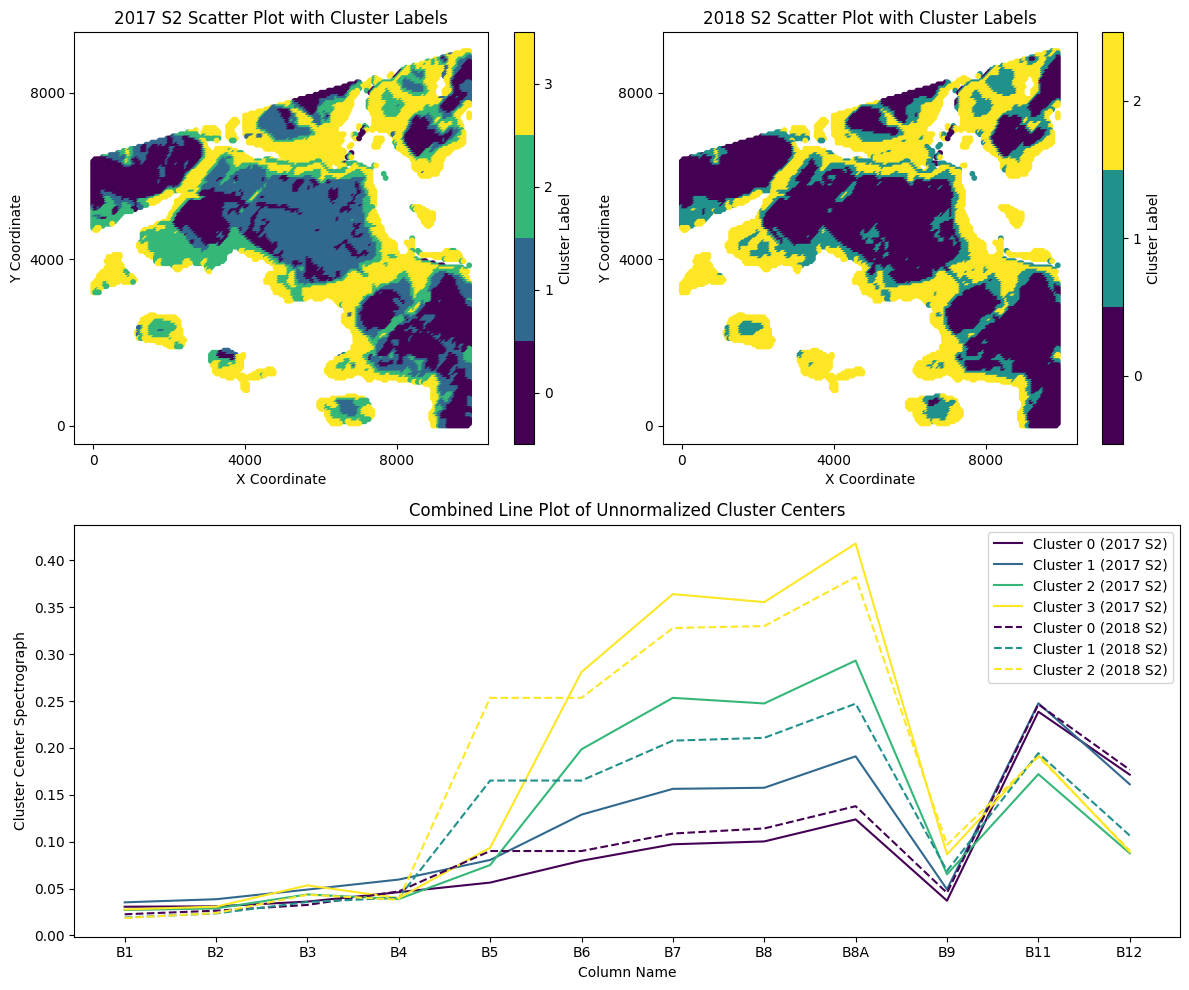

In [ ]:
# @title
##### Section 8 K Means Clustering ####

### Section 8.1 Perform K Means Clustering ###

# Prompt the user to choose the number of clusters for K-Means
num_clusters_1 = int(input("Enter the number of clusters for 2017 S2 K-Means: "))
num_clusters_2 = int(input("Enter the number of clusters for 2018 S2 K-Means: "))

# Initialize the K-Means model
kmeans_1 = KMeans(n_clusters=num_clusters_1, init = 'k-means++', n_init=1)
kmeans_2 = KMeans(n_clusters=num_clusters_2, init = 'k-means++', n_init=1)

# Fit the K-Means model to the normalized data
kmeans_1.fit(normalized_data_1)
kmeans_2.fit(normalized_data_2)

# Get the cluster labels for each data point
cluster_labels_1 = kmeans_1.labels_
cluster_labels_2 = kmeans_2.labels_

# Get the cluster centers
cluster_centers_1 = kmeans_1.cluster_centers_
cluster_centers_2 = kmeans_2.cluster_centers_

### Section 8.2 Sort the Cluster centers ###

# Calculate the distances of cluster centers from the origin (0, 0)
distances_from_origin_1 = np.sqrt(np.sum(cluster_centers_1 ** 2, axis=1))
distances_from_origin_2 = np.sqrt(np.sum(cluster_centers_2 ** 2, axis=1))

# Sort cluster centers based on distances from the origin
sorted_indices_1 = np.argsort(distances_from_origin_1)
sorted_indices_2 = np.argsort(distances_from_origin_2)

# Sort cluster centers and labels
sorted_cluster_centers_1 = cluster_centers_1[sorted_indices_1]
sorted_cluster_centers_2 = cluster_centers_2[sorted_indices_2]
sorted_cluster_labels_1 = np.zeros_like(cluster_labels_1)
sorted_cluster_labels_2 = np.zeros_like(cluster_labels_2)

# Relabel the cluster labels based on the sorted order
for new_label_1, old_label_1 in enumerate(sorted_indices_1):
    sorted_cluster_labels_1[cluster_labels_1 == old_label_1] = new_label_1

for new_label_2, old_label_2 in enumerate(sorted_indices_2):
    sorted_cluster_labels_2[cluster_labels_2 == old_label_2] = new_label_2

# Calculate the count of each cluster label
cluster_labels_count_1 = dict(zip(*np.unique(sorted_cluster_labels_1, return_counts=True)))
cluster_labels_count_2 = dict(zip(*np.unique(sorted_cluster_labels_2, return_counts=True)))

### Section 8.3 Denormalize the cluster centers ###

# Denormalize the data using the inverse transformation
cluster_centers_original_scale_1 = sorted_cluster_centers_1 * (max_vals_1.values - min_vals_1.values) + min_vals_1.values
cluster_centers_original_scale_2 = sorted_cluster_centers_2 * (max_vals_2.values - min_vals_2.values) + min_vals_2.values

### Section 8.4 Save results to CSV ###

# Output file names

# Create a DataFrame with X, Y, Cluster, and Remaining Data
clustered_data_df_1 = pd.DataFrame({
    'X': coordinates_1['X'],
    'Y': coordinates_1['Y'],
    'Cluster Number': sorted_cluster_labels_1,
    **{f'{col}': remaining_data_1[col] for col in remaining_data_1.columns}
})
clustered_data_df_2 = pd.DataFrame({
    'X': coordinates_2['X'],
    'Y': coordinates_2['Y'],
    'Cluster Number': sorted_cluster_labels_2,
    **{f'{col}': remaining_data_2[col] for col in remaining_data_2.columns}
})
clustered_data_df_1 = clustered_data_df_1.round(4)
clustered_data_df_2 = clustered_data_df_2.round(4)

# Create a DataFrame with Cluster center data
center_data_df_1 = pd.DataFrame(cluster_centers_original_scale_1, columns=remaining_data_1.columns)
center_data_df_2 = pd.DataFrame(cluster_centers_original_scale_2, columns=remaining_data_2.columns)

# Add a new column 'Cluster Number' to indicate the cluster number for each row
center_data_df_1.insert(0, 'Cluster Number', range(num_clusters_1))
center_data_df_2.insert(0, 'Cluster Number', range(num_clusters_2))
center_data_df_1 = center_data_df_1.round(4)
center_data_df_2 = center_data_df_2.round(4)

### Section 8.5 Plot KMeans Clustering results ###

# Create a single figure with three subplots
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Plot 1: Scatter Plot with Cluster Labels (2017 S2)
scatter_1 = ax1.scatter(coordinates_1['X'], coordinates_1['Y'], c=sorted_cluster_labels_1, cmap='viridis', marker='o', s=10)

# Set plot properties for Plot 1
ax1.set_title('2017 S2 Scatter Plot with Cluster Labels')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')

# Create a discrete color map with the number of clusters for Plot 1
cmap_discrete_1 = matplotlib.colormaps.get_cmap('viridis')

# Define boundaries for the discrete color map for Plot 1
boundaries_1 = np.arange(-0.5, num_clusters_1, 1)

# Create a BoundaryNorm for the color map for Plot 1
norm_discrete_1 = mcolors.BoundaryNorm(boundaries_1, cmap_discrete_1.N, clip=True)

# Add a discrete color bar with integer cluster labels for Plot 1
cbar_1 = plt.colorbar(scatter_1, ax=ax1, ticks=np.arange(num_clusters_1), cmap=cmap_discrete_1, norm=norm_discrete_1, boundaries=boundaries_1)
cbar_1.set_label('Cluster Label')

# Set the number of tick marks on the X and Y axes for Plot 1
ax1.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=3))

# Plot 2: Scatter Plot with Cluster Labels (2018 S2)
scatter_2 = ax2.scatter(coordinates_2['X'], coordinates_2['Y'], c=sorted_cluster_labels_2, cmap='viridis', marker='o', s=10)

# Set plot properties for Plot 2
ax2.set_title('2018 S2 Scatter Plot with Cluster Labels')
ax2.set_xlabel('X Coordinate')
ax2.set_ylabel('Y Coordinate')

# Create a discrete color map with the number of clusters for Plot 2
cmap_discrete_2 = matplotlib.colormaps.get_cmap('viridis')

# Define boundaries for the discrete color map for Plot 2
boundaries_2 = np.arange(-0.5, num_clusters_2, 1)

# Create a BoundaryNorm for the color map for Plot 2
norm_discrete_2 = mcolors.BoundaryNorm(boundaries_2, cmap_discrete_2.N, clip=True)

# Add a discrete color bar with integer cluster labels for Plot 2
cbar_2 = plt.colorbar(scatter_2, ax=ax2, ticks=np.arange(num_clusters_2), cmap=cmap_discrete_2, norm=norm_discrete_2, boundaries=boundaries_2)
cbar_2.set_label('Cluster Label')

# Set the number of tick marks on the X and Y axes for Plot 2
ax2.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=3))

# Plot 3: Line Plot of Combined Unnormalized Cluster Centers
for cluster_label_1 in range(num_clusters_1):
    color_1 = cmap_discrete_1(cluster_label_1 / (num_clusters_1 - 1))  # Match color from scatter plot (2017 S2)
    ax3.plot(remaining_data_1.columns, cluster_centers_original_scale_1[cluster_label_1], label=f'Cluster {cluster_label_1} (2017 S2)', color=color_1)

for cluster_label_2 in range(num_clusters_2):
    color_2 = cmap_discrete_2(cluster_label_2 / (num_clusters_2 - 1))  # Match color from scatter plot (2018 S2)
    ax3.plot(remaining_data_2.columns, cluster_centers_original_scale_2[cluster_label_2], '--', label=f'Cluster {cluster_label_2} (2018 S2)', color=color_2)

# Set plot properties for Plot 3
ax3.set_title('Combined Line Plot of Unnormalized Cluster Centers')
ax3.set_xlabel('Column Name')
ax3.set_ylabel('Cluster Center Spectrograph')
ax3.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
